In [1]:
from pathlib import Path
import pandas as pd
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [2]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

#creating 2 columns to identify source file and if ios or android
df_ios = pd.read_csv(root / "data" / "processed" / "ios" / "parent_clean.csv", header=0)
df_ios.head() 

,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,...,gpsP75LateralAccel,gpsP95LateralAccel,bearing_angular_change_per_second,gyro_angular_change_per_second,bearingAngleChange,gyroAngleChange,mems_radius,gps_radius,speed_gap,aggressive
0,1,ios_turns.csv,4.0,8.553064,5.321719,0.014196,2.0,5.384603,8.536157,9.551594,...,1.414616,1.659606,14.507535,17.503620,72.763930,93.844490,5.143511,20.190279,1.015437,0
1,1,ios_turns.csv,4.0,9.360758,4.884875,0.012575,2.0,5.895552,9.034532,10.596797,...,0.323955,2.006506,6.688964,7.615370,28.435398,37.502575,21.282076,56.273140,1.562265,0
2,1,ios_turns.csv,5.0,10.681455,8.657750,0.021795,2.0,5.291993,11.082506,10.390737,...,0.639127,0.752962,4.451903,6.722845,42.455890,58.471710,61.868423,60.049355,-0.691769,0
3,1,ios_turns.csv,5.0,10.399240,7.823751,0.016130,2.0,4.910240,15.013917,8.630282,...,0.135585,6.447024,12.498045,12.015339,97.785550,94.482200,11.925367,inf,-6.383635,0
4,1,ios_turns.csv,4.0,8.345368,7.148625,0.017785,2.0,4.965302,6.963474,9.905923,...,0.968915,1.698010,10.938344,11.460243,35.474804,82.380120,8.483684,16.327477,2.942449,0


In [3]:
# eventType = 4 for turning left, eventType = 5 for turning right
# is_ios = 0 for Android, is_ios = 1 for iOS

sub_df_left = df_ios[df_ios['eventType'] == 4]
sub_df_right = df_ios[df_ios['eventType'] == 5]


In [4]:
sub_df_left.shape

(27067, 27)

In [5]:
features_to_plot = [
    'eventDurationSeconds',
    'eventMilesDriven',
    'eventStartSpeed',
    'eventEndSpeed',
    #'eventSpeedChange',
    'memsMedianHorizontalNorm',
    'gyro_angular_change_per_second',
    'gyroAngleChange',
    'mems_radius'
]

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sub_df_left[features_to_plot])

scaled_df = pd.DataFrame(scaled_data, columns=features_to_plot)

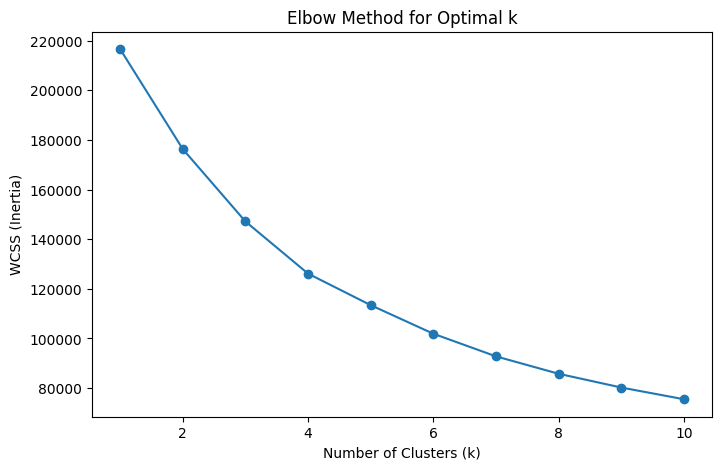

In [6]:
# Use elbow method to get optimal number of clusters
wcss = []
k_range = range(1, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.show()

,k,Silhouette Score,Calinski-Harabasz Score
0,2,0.213031,5495.483903
1,3,0.245239,6385.918345
2,4,0.247185,5505.813876
3,5,0.248425,6142.018222
4,6,0.224273,6090.915691
5,7,0.209339,5851.963228
6,8,0.212522,5895.474255
7,9,0.199553,5286.221737
8,10,0.207390,5602.077572


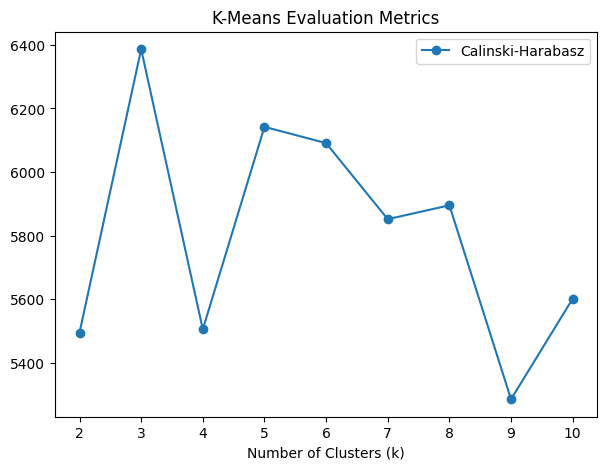

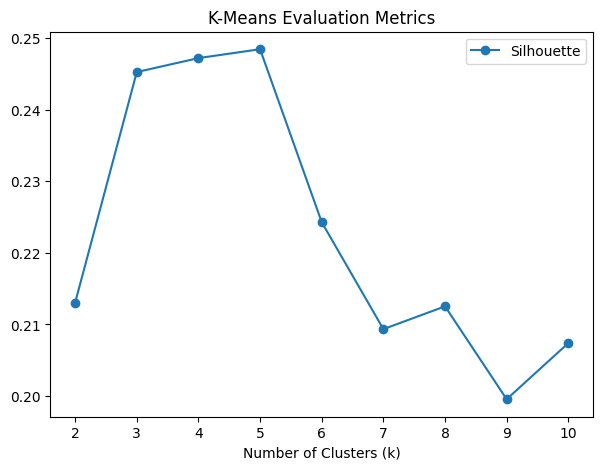

In [7]:
#performance metric to look at cluster quality 
results = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_df)
    labels = kmeans.labels_
    
    sil_score = silhouette_score(scaled_df, labels)
    ch_score = calinski_harabasz_score(scaled_df, labels)
    
    results.append({
        'k': k,
        'Silhouette Score': sil_score,
        'Calinski-Harabasz Score': ch_score
    })
    
    scaled_df_clustered = scaled_df.copy()
    scaled_df_clustered['klabel'] = labels

results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(7, 5))
plt.plot(results_df['k'], results_df['Calinski-Harabasz Score'], marker='o', label='Calinski-Harabasz')
plt.title('K-Means Evaluation Metrics')
plt.xlabel('Number of Clusters (k)')
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(results_df['k'], results_df['Silhouette Score'], marker='o', label='Silhouette')
plt.title('K-Means Evaluation Metrics')
plt.xlabel('Number of Clusters (k)')
plt.legend()
plt.show()

/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


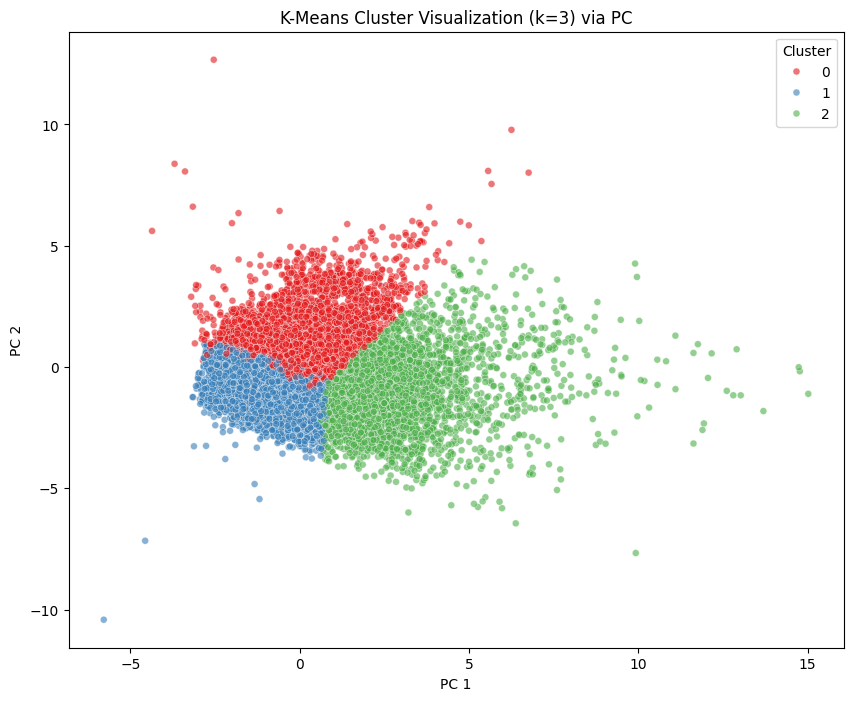

In [8]:
kmeans_final = KMeans(n_clusters=3, n_init=10)
kmeans_final.fit(scaled_df)
final_labels = kmeans_final.labels_

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster_Label'] = final_labels

cluster_centers_pca = pca.transform(kmeans_final.cluster_centers_)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster_Label',
    data=pca_df, 
    palette='Set1',
    alpha=0.6,
    s=25
)

plt.title('K-Means Cluster Visualization (k=3) via PC')
plt.xlabel(f'PC 1')
plt.ylabel(f'PC 2')
plt.legend(title='Cluster')
plt.show()

In [9]:
kmeans_final = KMeans(n_clusters=3, n_init=10) 
kmeans_final.fit(scaled_df)
final_labels = kmeans_final.labels_

df_clustered = sub_df_left.copy()

/var/folders/gb/z580gbzd2snggl2ym34nk9000000gn/T/ipykernel_7990/1408649164.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


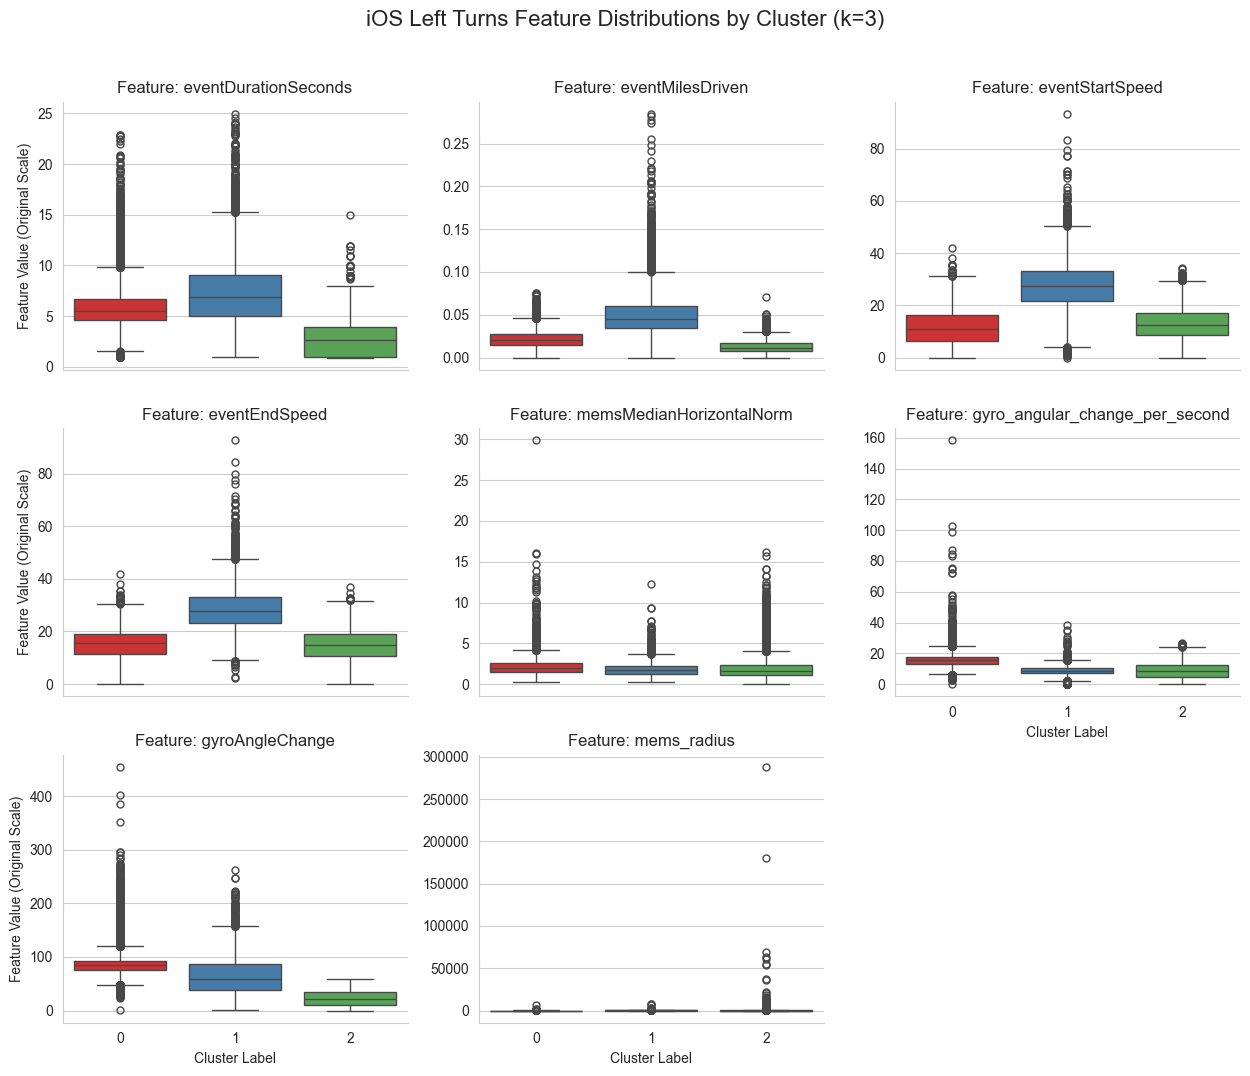

In [10]:

df_clustered['Cluster_Label'] = final_labels
df_clustered['Cluster_Label'] = df_clustered['Cluster_Label'].astype('category')

df_melted = df_clustered[['Cluster_Label'] + features_to_plot].melt(
    id_vars=['Cluster_Label'],
    var_name='Feature',
    value_name='Value'
)

sns.set_style("whitegrid")
g = sns.catplot(
    data=df_melted,
    x='Cluster_Label',
    y='Value',
    col='Feature',
    kind='box', 
    col_wrap=3, 
    palette='Set1',
    sharey=False,
    height=3.5,
    aspect=1.2  
)

g.fig.suptitle('iOS Left Turns Feature Distributions by Cluster (k=3)', y=1.02, fontsize=16)
g.set_titles("Feature: {col_name}", size=12)
g.set_axis_labels("Cluster Label", "Feature Value (Original Scale)", size=10) 
plt.tight_layout()
plt.show()

In [11]:
pca_3d = PCA(n_components=3)
pca_resulpca_3d = PCA(n_components=3)
pca_result = pca_3d.fit_transform(scaled_df)

kmeans_3d = KMeans(n_clusters=3, n_init=10)
labels_3d = kmeans_3d.fit_predict(pca_result)
t = pca_3d.fit_transform(scaled_df)


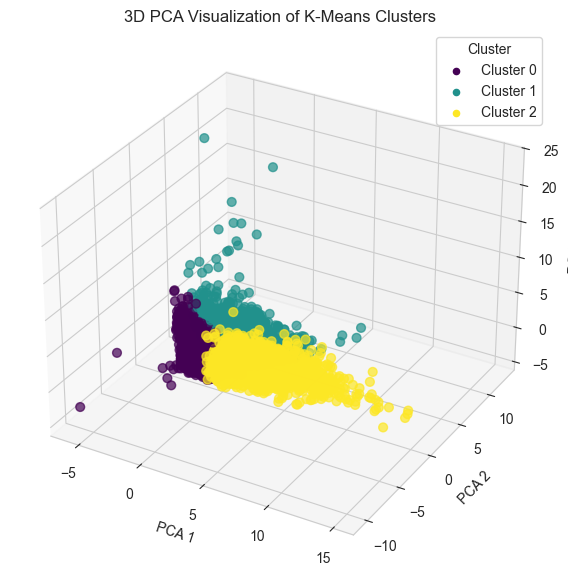

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
    c=labels_3d, cmap='viridis', s=40, alpha=0.7
)
#cmap='viridis' sets the color palette
#s=40 sets the size of each point
#alpha=0.7 makes the points slightly transparent

ax.set_title('3D PCA Visualization of K-Means Clusters')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# Legend
legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']
legend_colors = [scatter.cmap(scatter.norm(i)) for i in range(3)]
for label, color in zip(legend_labels, legend_colors):
    ax.scatter([], [], [], c=[color], label=label)
ax.legend(title='Cluster')

plt.show()
